# Сборный проект 1

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

🎯 Вам нужно _выявить определяющие успешность игры закономерности_. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года.

Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## 1. Общая информация о датасете

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df = pd.read_csv('games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


16 715 записей

пропуски:

In [4]:
df.isna().sum() / df.shape[0]

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

## Шаг 2. Подготовьте данные

- Замените названия столбцов (приведите к нижнему регистру);

In [5]:
df.columns = [col.lower() for col in df.columns]

- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему
- Обработайте пропуски при необходимости:
  - Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
  - Опишите причины, которые могли привести к пропускам;
  - Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать;
----------------

- есть две записи с незаполненным названием и жанром, выкинем их
- заполним пропуски в объёмах продаж на 0, там пара пропусков про никому неизвестные игры
- выкинем 1.6% записей с пустым годом выпуска и скастуем к инту
- заполним пропуски в оценке критиков значением в -1, пропусков половина,
  у почти всех пропусков нет также и оценки пользователем

In [6]:
nans = list(df[df.name.isna()].index)
df.drop(index=nans, inplace=True)

df.dropna(subset=['year_of_release'], inplace=True)
df.year_of_release = df.year_of_release.astype('int')

df.na_sales.fillna(0, inplace=True)
df.eu_sales.fillna(0, inplace=True)
df.jp_sales.fillna(0, inplace=True)
df.other_sales.fillna(0, inplace=True)

df.critic_score.fillna(-1, inplace=True)

- будем считать tbd как пропуск
заполним все пропуска в рейтинге пользователей -1
- заменим типы в рейтинге пользователей со строки на целочисленный тип

In [7]:
df[df.user_score == 'tbd'] = '-1'
df.user_score = df.user_score.fillna('-1')
df.user_score = df.user_score.astype('float')

- пропуски в rating тоже заполним -1

In [8]:
df.rating = df.rating.fillna('-1')

In [9]:
df.head(30)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,-1
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.0,-1.0,-1.0,-1
5,Tetris,GB,1989,Puzzle,23.2,2.26,4.22,0.58,-1.0,-1.0,-1
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.5,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.7,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,-1


- Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [10]:
df['sales'] = df.na_sales + df.jp_sales + df.eu_sales + df.other_sales

## Шаг 3. Проведите исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
До 1994 игр особо и не выпускалось, но мы возьмём данные за последние 10 лет, под старые платформы игры сейчас не продаются
Продажи постоянно падают

In [11]:
df.year_of_release = df.year_of_release.astype('int')
df = df[df.year_of_release >= 2007]
by_years = df.groupby('year_of_release').name.count()
by_years

# https://github.com/druzyk/DS_projects/blob/master/4_video_games_analysis.ipynb
# https://github.com/akrisanov/data-science-cource/blob/master/sprint5/notebook.ipynb
# https://github.com/Higem11/Yandex-Data-Analysis/blob/master/5%20%D0%A1%D0%B1%D0%BE%D1%80%D0%BD%D1%8B%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%201%20-%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%20%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%B8%D0%B3%D1%80%D0%BE%D0%B2%D0%BE%D0%B9%20%D0%B8%D0%BD%D0%B4%D1%83%D1%81%D1%82%D1%80%D0%B8%D0%B8.ipynb

year_of_release
2007    1005
2008    1101
2009    1021
2010     924
2011     919
2012     629
2013     529
2014     560
2015     568
2016     468
Name: name, dtype: int64

- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами
и постройте распределение по годам.
За какой характерный срок появляются новые и исчезают старые платформы?

In [12]:
by_platform = df.loc[df.platform != '-1'].groupby('platform').sales.sum().sort_values(ascending=False)
by_platform

platform
PS3     900.63
X360    888.94
Wii     655.84
DS      394.50
PS4     314.00
3DS     253.24
PSP     169.89
PC      159.06
XOne    158.77
PS2     133.18
WiiU     81.79
PSV      53.50
GBA       3.21
XB        0.73
GC        0.22
DC        0.06
Name: sales, dtype: float64

берём топ 10

<AxesSubplot:xlabel='year_of_release'>

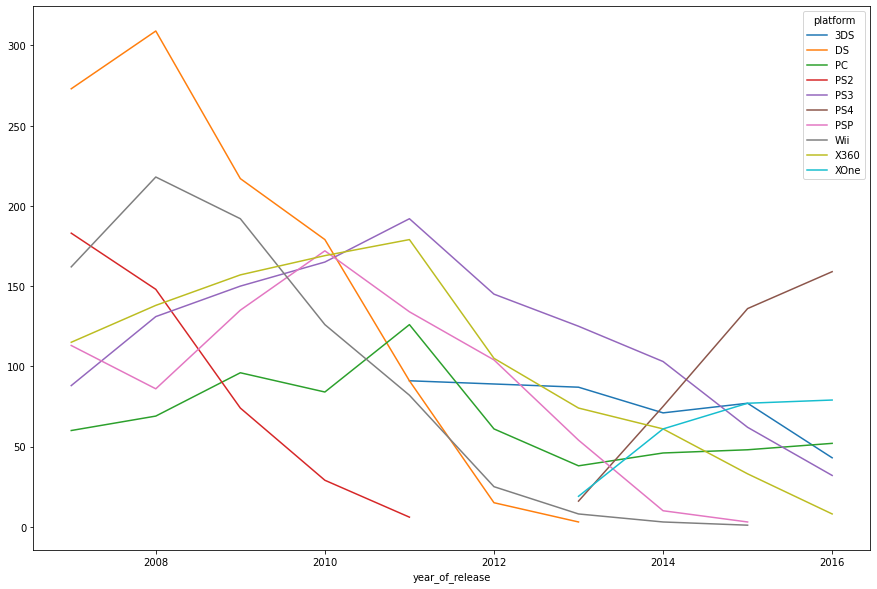

In [13]:
platform_top = list(by_platform.iloc[:10].index)
tmp = df.loc[df.platform.isin(platform_top)].groupby(['platform', 'year_of_release']).name.count()
tmp.unstack(level=0).plot(figsize=(15, 10))

Устойчиво растёт PS4
Немного растут ПК и Xone
3DS, PS3, X360 падают, последняя вообще скорее всего в следующем году исчезнет
PS2, DC, Wii, PSP исчезли

- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных
платформ.

Лидируют по продажам в последние 10 лет 'PS3', 'X360', 'Wii', 'DS', 'PS4', '3DS', 'PSP', 'PC', 'XOne', 'PS2'

Брать надо PS4, PC, Xone, можно 3DS, PS3

- Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.
Велика ли разница в продажах?
А в средних продажах на разных платформах? Опишите результат.

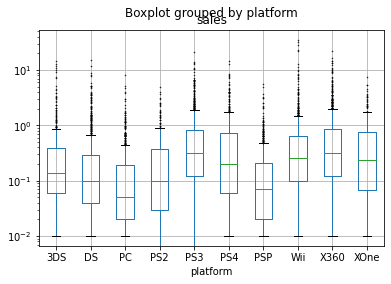

In [35]:
df.reset_index(drop=True, inplace=True)

ax = df.loc[df.platform.isin(platform_top)].boxplot(by='platform', column=['sales'],
                          flierprops={'marker': '.',
                                      'markersize': 1
                                      })
ax.set_yscale('log')

Разница в средних продажах в несколько раз, разница в продажах топовых игр ещё более существенная

Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

<AxesSubplot:xlabel='sales', ylabel='user_score'>

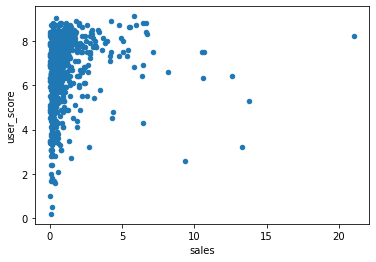

In [42]:
df[(df.platform == 'PS3') & (df.user_score > 0)].plot(kind='scatter', x='sales', y='user_score')

<AxesSubplot:xlabel='sales', ylabel='critic_score'>

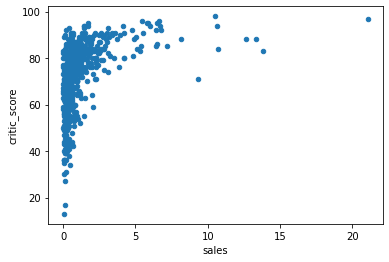

In [45]:
df[(df.platform == 'PS3') & (df.critic_score > 0)].plot(kind='scatter', x='sales', y='critic_score')

In [57]:
tmp = df[(df.platform == 'PS3') & (df.user_score > 0) & (df.critic_score > 0)] \
    [['sales', 'user_score', 'critic_score']]

In [ ]:
tmp.critic_score = tmp.critic_score.astype('float')
tmp.sales = tmp.sales.astype('float')

In [69]:
tmp.corr()

,sales,user_score,critic_score
sales,1.000000,0.141541,0.428447
user_score,0.141541,1.000000,0.630960
critic_score,0.428447,0.630960,1.000000


Есть существенная корреляция между оценками и продажами